In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import geopandas as gpd
import geojson
from geojson import MultiPoint
import json
from sklearn.cluster import Birch

# 1. Motivation

### What is your dataset?
The dataset that was picked for this project is one that includes all reported crimes in New York City[3] from 2006 through 2017. Each crime is one line with 35 variables to describe the reported crime in various ways. As an example the location of the crime is available in geographical coordinates and also where within the city it occured (both police precinct and Borough). Data about the suspect and the victim is available (race, sex and to what age group they belong). The date and time of the report is also included in the data.
    
### Why did you choose this/these particular dataset(s)?
This particular dataset was chosen because New York City is one of the most well known cities in the world with many aspects in mind (culture, business, tourism, crime) and crime is one of them. Is it possible to understand the crime committed in New York City in some way. Can the data identify some regions of high crime rates? Can anything be gauged by looking at the police precincts and victim demographics?
    
### What was your goal for the end user's experience?
The goal for the end user's experience was to not restrict the narrative of the data to much. Each person is interested in looking at the crime from their own perspective and are looking for answers to different questions from the data. This means that each visualization should contain some interactivity to allow the user to look at only the part of the data that he/she is interested in. Of course it is impossible to satisfy everyone and to represent all aspect of the data is beyond the scope of this project, but some aspects of it will be represented across various visualizations.

# 2. Basic Stats

### Write about your choices in data cleaning and preprocessing.
The dataset of crime reports in New York City is a total of 1.85 GB. This is to big to work with in IPython Notebook since it seems to create some memory problems. To get rid of some data it was decided to only include the most recent five years in the analysis (2013-2017). Furthermore it was decided to get rid of any and all data records that were missing some key variables, namely records that did not contain any data for the date and time of the report. When dealing with analysis where the crime locations was of interest the records with missing locations were also omitted. 
    Before starting to analyze the data it was also decided to parse some of the variables into a format that is better to work with. The date- and timestamps were parsed into python date and time objects and additional columns were created for the year, month, day of month, week and day of week each crime was commited. All these new columns make it easier to explore and analyze the data on different time scales. Additionally every missing value in the file was filled with an appropriate value indicating that this variable is not known for the record.

In [8]:
# Read the .csv file
df = pd.read_csv("Data/NYPD_Complaint_Data_2013_plus.csv", low_memory=False)

#Define function that are used to process the data
def get_year(x):
    return x.year

def get_month(x):
    return x.month

def get_day(x):
    return x.day

def get_hour(x):
    return x.hour

def get_minute(x):
    return x.minute

def get_week(x):
    return x.isocalendar()[1]

def get_weekday(x):
    return x.isoweekday()#int(x.strftime("%w"))

def convert_to_time(x):
    if type(x) == str:
        return dt.datetime.strptime(x, "%H:%M:%f")
    else:
        return None

def merge_date_and_time(d, t):
    if type(d) == str and type(t) == str:
        return dt.datetime.strptime("{0} {1}".format(d, t), "%m/%d/%Y %H:%M:%f")
    else:
        return None

# Drop all records with no recorded date or time
df = df[pd.notna(df["CMPLNT_FR_DT"])]
df = df[pd.notna(df["CMPLNT_FR_TM"])]
df["Date"] = pd.Series(np.vectorize(dt.datetime.strptime)(df["CMPLNT_FR_DT"].values, "%m/%d/%Y"))
df = df[pd.notna(df["Date"])]
df["Time"] = pd.Series(np.vectorize(convert_to_time)(df["CMPLNT_FR_TM"].values))

# Create various columns for the date and time
df["Datetime"] = pd.Series(np.vectorize(merge_date_and_time)(df["CMPLNT_FR_DT"].values, df["CMPLNT_FR_TM"].values))
df = df[pd.notna(df["Datetime"])]
df = df[df["Datetime"] >= dt.datetime(2006,1,1)]
df["Year"] = pd.Series(np.vectorize(get_year)(df["Date"].values))
df["Month"] = pd.Series(np.vectorize(get_month)(df["Date"].values))
df["Day"] = pd.Series(np.vectorize(get_day)(df["Date"].values))
df["Hour"] = pd.Series(np.vectorize(get_hour)(df["Datetime"].values))
df["Minute"] = pd.Series(np.vectorize(get_minute)(df["Datetime"].values))
df["Week"] = pd.Series(np.vectorize(get_week)(df["Datetime"].values))
df["Weekday"] = pd.Series(np.vectorize(get_weekday)(df["Datetime"].values))

# Only keep data from 2013 and onwards
df = df[df["Year"]>=2013].copy()

# Fill missing values with appropriate values
df.fillna(value={"ADDR_PCT_CD": -1.0, "LAW_CAT_CD": "UNKNOWN", "BORO_NM": "UNKNOWN",
                 "OFNS_DESC": "UNKNOWN", "PD_DESC": "UNKNOWN", "VIC_AGE_GROUP": "UNKNOWN",
                 "VIC_SEX": "UNKNOWN", "VIC_RACE": "UNKNOWN"}, inplace=True)
age_groups_all = set(np.unique(df["VIC_AGE_GROUP"].values))
age_groups = ["<18", "18-24", "25-44", "45-64", "65+", "UNKNOWN", "OTHER"]
# Rename age groups that are not self explanatory as 'OTHER'
df.loc[df["VIC_AGE_GROUP"].isin(set(age_groups_all.difference(set(age_groups)))), "VIC_AGE_GROUP"] = "OTHER"

### Write a short section that discusses the dataset stats, containg key points/plots from your exploratory data analysis.
The attributes that are interesting to investigate are a few. The locations of the crimes can possibly shed some light on some hazardous areas of the city. By looking at a histogram of all the crime locations it is clear that there is a peak between -74.0° and -74.9° longitude whereas the crimes are more spread out along the latitude of the city. This rougly corresponds to a higher crime rate in and around Manhattan, the Bronx and Brooklyn compared to crime rates in Staten Island and Queens. This can be seen on the following figure. When looking at the histogram for the different types of crimes committed in the five years it is evident that some crime types occur much less than others. Let us only look at the crime types that occur 5000 times or more across the five years being explored. This leaves us with 28 of the original 69 crime types.

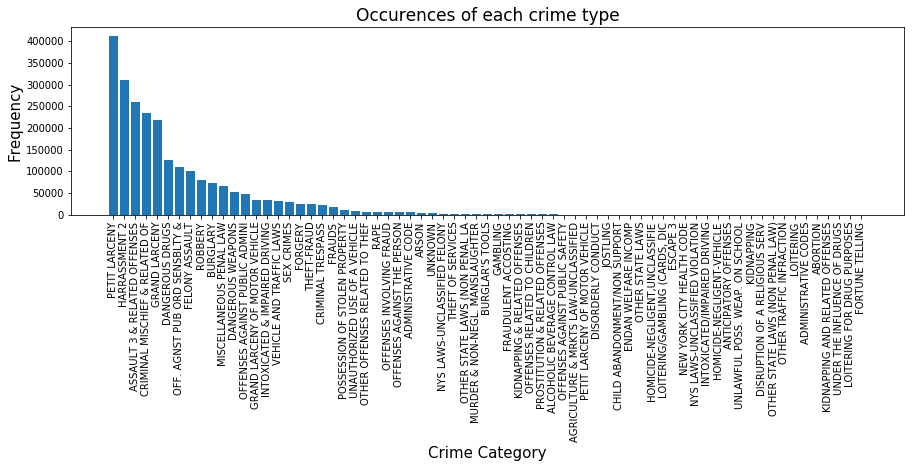

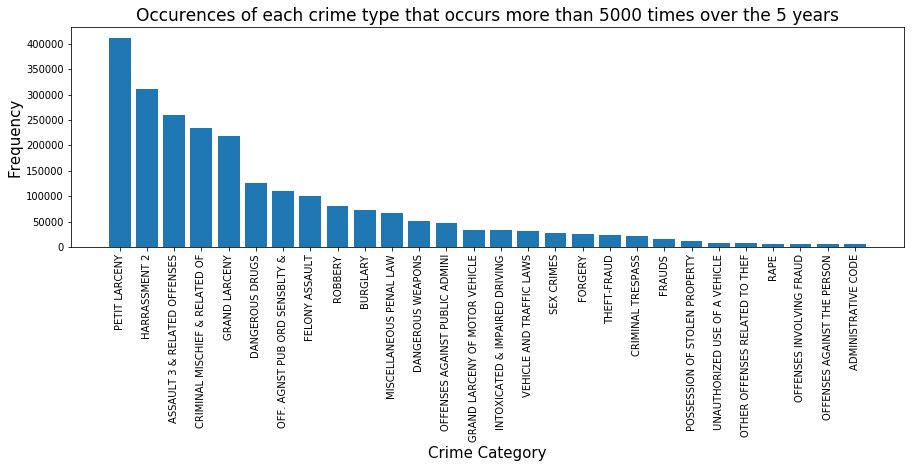

In [49]:
hist_crimes = df[["OFNS_DESC", "Time"]].groupby(by="OFNS_DESC", as_index=False).count()
hist_crimes = hist_crimes.sort_values(by="Time", ascending=False)
plt.figure(figsize=(12.8, 6.6))
plt.bar(hist_crimes["OFNS_DESC"].values, hist_crimes["Time"].values)
plt.xlabel("Crime Category", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of each crime type", fontsize=17)
plt.xticks(rotation=90)
plt.tight_layout()

hist_focuscrimes = hist_crimes.sort_values(by="Time", ascending=False)
hist_focuscrimes = hist_focuscrimes[(hist_focuscrimes["Time"]>5000)]
plt.figure(figsize=(12.8, 6.6))
plt.bar(hist_focuscrimes["OFNS_DESC"].values, hist_focuscrimes["Time"].values)
plt.xlabel("Crime Category", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of each crime type that occurs more than 5000 times over the 5 years", fontsize=17)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Looking at the age of the victims it can be seen that the majority of victims are between the age of 25 and 64 years old. An alarming amount of records do not account for the age of the victim giving rise to big "UNKNOWN" bar on the bar plot.

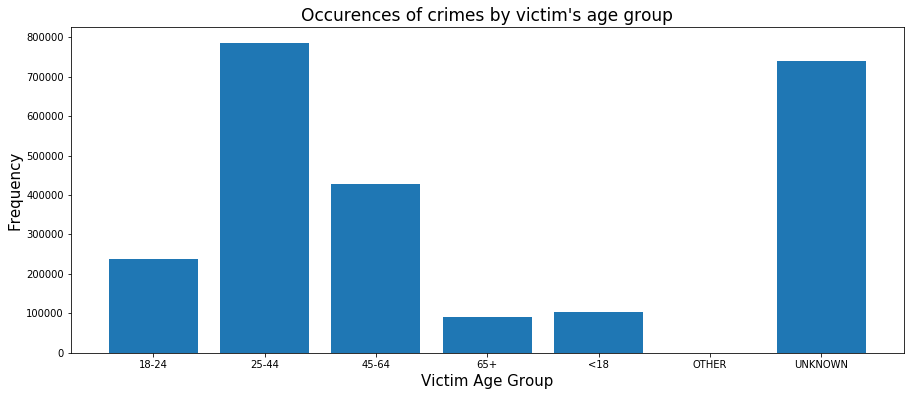

In [41]:
hist_vicage = df[["VIC_AGE_GROUP", "Time"]].groupby(by="VIC_AGE_GROUP", as_index=False).count()
plt.figure(figsize=(12.8, 5.6))
plt.bar(hist_vicage["VIC_AGE_GROUP"].values, hist_vicage["Time"].values)
plt.xlabel("Victim Age Group", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by victim's age group", fontsize=17)
plt.tight_layout()
plt.show()


Similarly the sex of the victims can be explored. The majority of victims are either male or female, as was expected, but some are marked with other sex groups that are not known and are not described on the web page that published the data set.

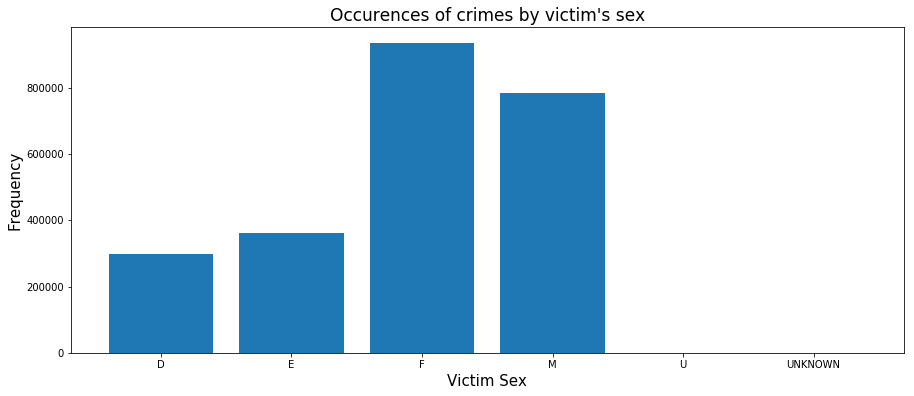

In [42]:
hist_vicsex = df[["VIC_SEX", "Time"]].groupby(by="VIC_SEX", as_index=False).count()
plt.figure(figsize=(12.8, 5.6))
plt.bar(hist_vicsex["VIC_SEX"].values, hist_vicsex["Time"].values)
plt.xlabel("Victim Sex", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by victim's sex", fontsize=17)
plt.tight_layout()
plt.show()

# 3. Data Analysis

Looking at the temperal evolution of how many crimes are committed a few interesting things can be seen. Firstly it seems that on average the first day of a month has higher crime rates than the other days. If crime rates on weekly basis are investigated it turns out that the average number of crimes commited each week plummets every fourth week and then rises again for 3 weeks. Also more crime seems to be commited over the summer time compared to other seasons of the year. All of this is deducted from looking at the total crimes commited. By looking at only one, or a few crime types at a time perhaps some slightly different patterns emerge. At the least one can see if there is a rise or a decrease in the crime rates of the individual crimes. 



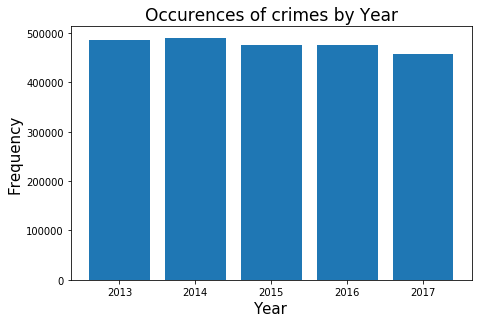

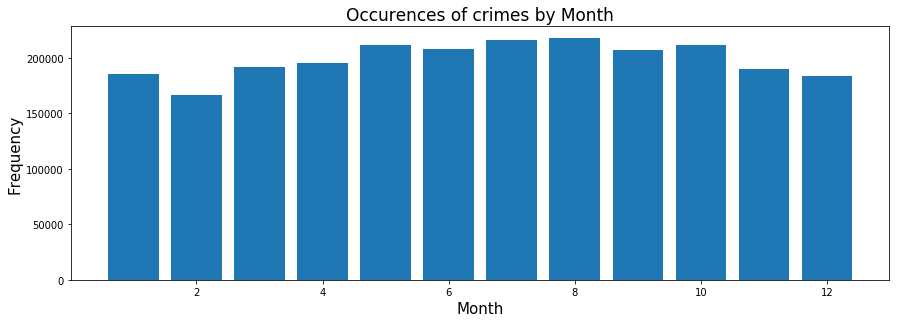

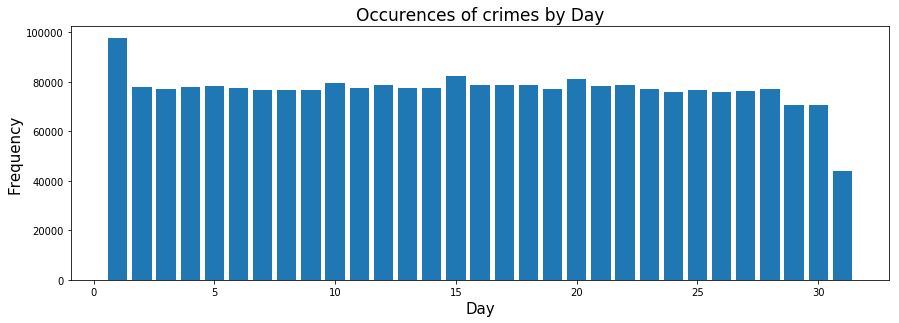

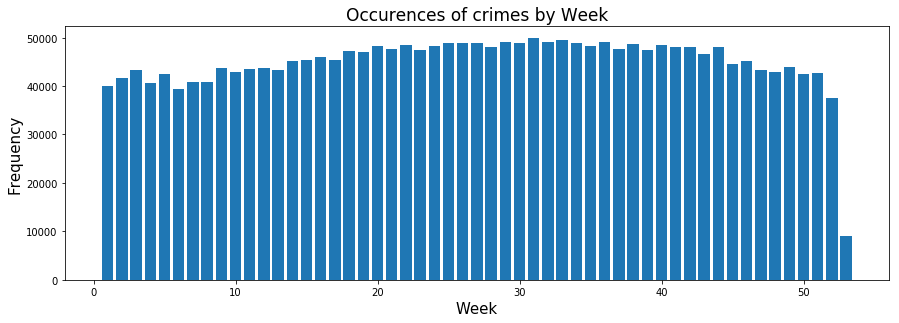

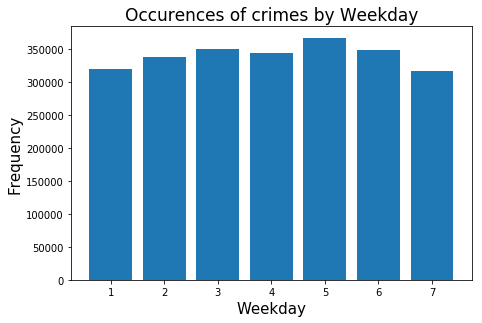

In [39]:
hist_year = df[["Year", "Time"]].groupby(by="Year", as_index=False).count()
plt.figure(figsize=(6.8, 4.6))
plt.bar(hist_year["Year"].values, hist_year["Time"].values)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by Year", fontsize=17)
plt.tight_layout()

hist_month = df[["Month", "Time"]].groupby(by="Month", as_index=False).count()
plt.figure(figsize=(12.6, 4.6))
plt.bar(hist_month["Month"].values, hist_month["Time"].values)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by Month", fontsize=17)
plt.tight_layout()

hist_day = df[["Day", "Time"]].groupby(by="Day", as_index=False).count()
plt.figure(figsize=(12.6, 4.6))
plt.bar(hist_day["Day"].values, hist_day["Time"].values)
plt.xlabel("Day", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by Day", fontsize=17)
plt.tight_layout()

hist_week = df[["Week", "Time"]].groupby(by="Week", as_index=False).count()
plt.figure(figsize=(12.6, 4.6))
plt.bar(hist_week["Week"].values, hist_week["Time"].values)
plt.xlabel("Week", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by Week", fontsize=17)
plt.tight_layout()

hist_weekday = df[["Weekday", "Time"]].groupby(by="Weekday", as_index=False).count()
plt.figure(figsize=(6.8, 4.6))
plt.bar(hist_weekday["Weekday"].values, hist_weekday["Time"].values)
plt.xlabel("Weekday", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Occurences of crimes by Weekday", fontsize=17)
plt.tight_layout()

plt.show()

Further more, by plotting the locations of crime reports on a weekly basis for the five years it comes to light that the pattern of crime locations changes a little between weeks and the majority of crime always lies within Manhattan, the Bronx and Brooklyn. Crime rates in Staten Island and Queens seems to be much lower.



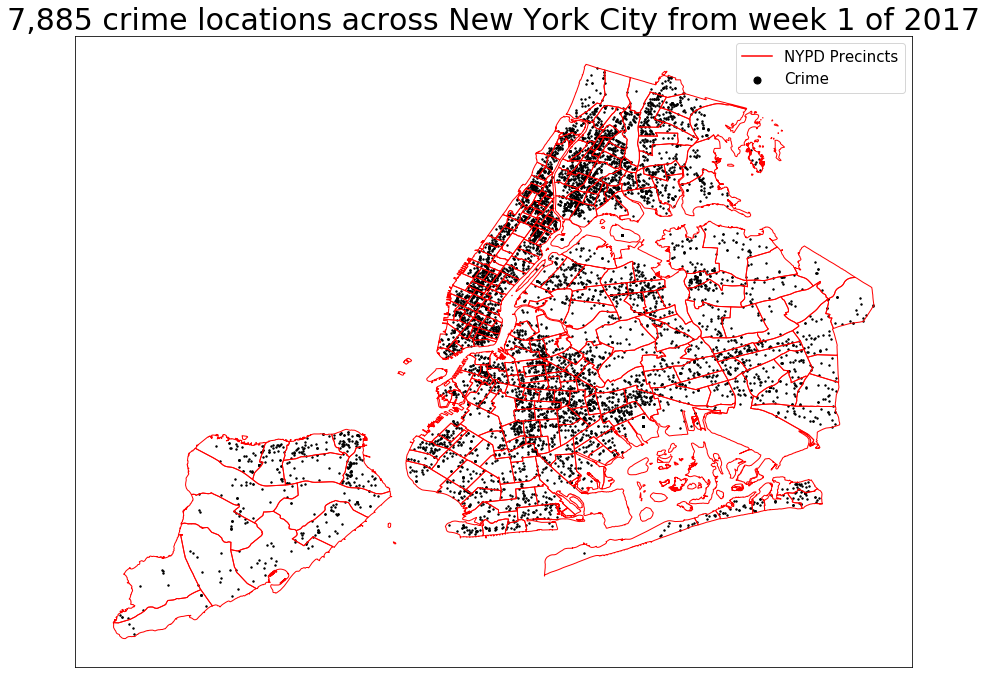

In [47]:
df_precinct = gpd.read_file(os.path.join("Data", "NYPD_Sectors.geojson"))
fig,ax = plt.subplots(figsize=(15,15))
lats_week = df[(df["Week"]==1) & (df["Year"]==2017) & (pd.notna(df["Latitude"]))]["Latitude"].values
lons_week = df[(df["Week"]==1) & (df["Year"]==2017) & (pd.notna(df["Longitude"]))]["Longitude"].values
ax.set_aspect("equal")
ax.scatter(lons_week, lats_week, zorder=0, edgecolor="k", marker="o", s=2, label="Crime", facecolor="k")
df_precinct.plot(ax=ax, edgecolor="red", color="None", zorder=1, linewidth=1)
plt.title("{0:,} crime locations across New York City from week 1 of 2017".format(len(lats_week)), fontsize=30)
plt.savefig(os.path.join("Video", "NY_map_week.png"))
plt.plot([], [], 'r-', label="NYPD Precincts")
plt.legend(fontsize=15, markerscale=5)
plt.xticks([])
plt.yticks([])
plt.show()

In an attempt to find some pattern to the geological location a simple clustering algorithm is applied to the locations on a weekly basis. The only input used are the latitude and longitude of the crimes. A more detailed clustering could be applied, but that is a whole other project in it self. The clusters seem to form in the same areas as the majority of the crimes are committed, i.e. one or two in Manhattan, the Bronx and Brooklyn respectively. Other clusters exist for the rest of the data, but they are much less dense then the other mentioned clusters.

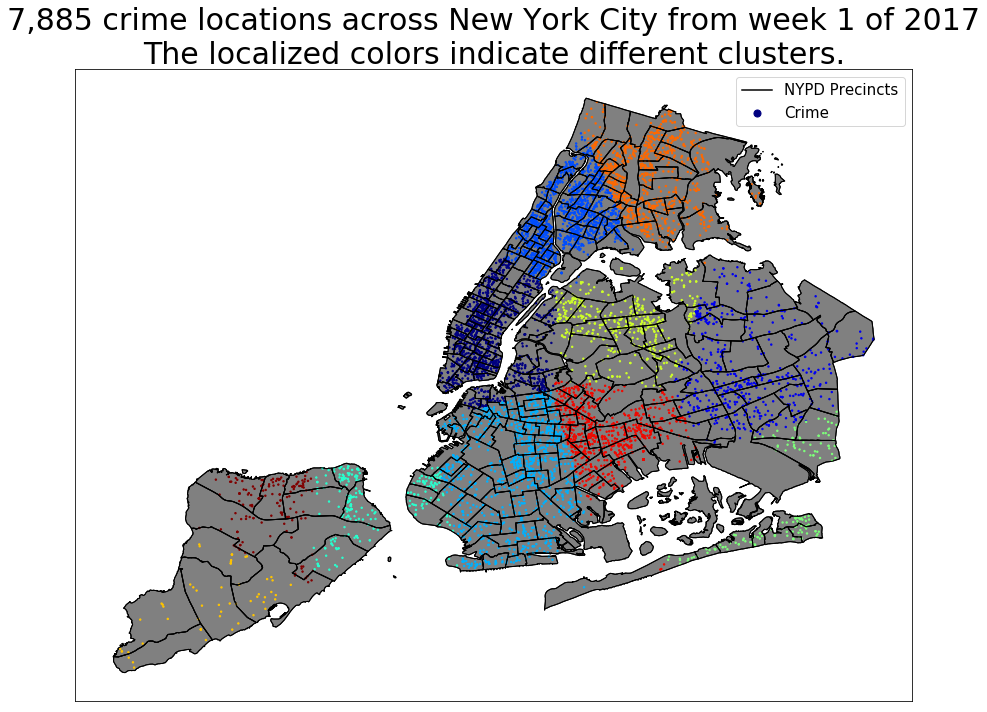

In [53]:
X = df[(df["Week"]==1) & (df["Year"]==2017) & (pd.notna(df["Latitude"]))][["Longitude", "Latitude"]].values

brc = Birch(branching_factor=50, n_clusters=None, threshold=0.05, compute_labels=True)
brc.fit(X)
l = brc.predict(X)
df_precinct = gpd.read_file(os.path.join("Data", "NYPD_Sectors.geojson"))
fig,ax = plt.subplots(figsize=(15,15))
df_precinct.plot(ax=ax, edgecolor="black", color="gray", zorder=-1, linewidth=1)
lats_week = df[(df["Week"]==1) & (df["Year"]==2017) & (pd.notna(df["Latitude"]))]["Latitude"].values
lons_week = df[(df["Week"]==1) & (df["Year"]==2017) & (pd.notna(df["Longitude"]))]["Longitude"].values
ax.set_aspect("equal")
ax.scatter(lons_week, lats_week, zorder=0, c=l, marker="o", s=2, label="Crime", facecolor="k", cmap="jet")
df_precinct.plot(ax=ax, edgecolor="black", color="None", zorder=1, linewidth=1)
plt.title("{0:,} crime locations across New York City from week 1 of 2017\nThe localized colors indicate different clusters.".format(len(lats_week)), fontsize=30)
plt.savefig(os.path.join("Video", "NY_map_week.png"))
plt.plot([], [], 'k-', label="NYPD Precincts")
plt.legend(fontsize=15, markerscale=5)
plt.xticks([])
plt.yticks([])
plt.show()

Because of the freedom of interaction that is a goal for the visualization it is hard to describe each part of the data analysis that is possible on the data. Just by looking at the crime types we are considering there are 28 trends that would need to be described and even more if one considers either more than one crime type at a time or compares two or more types against one another. The reader is encouraged to check out the visual narrative and explore the data there to find out what they are interested in finding out from the presented data.

# 4. Genre

The genre that was picked for the visualization is the interactive slideshow genre where one slide is a small independent visualization on it's own that follows the Drill-Down Story genre or the Partitioned Poster genre, allowing the reader to freely interact with the slide to view the data according to what they are interested in.

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
The 3 categories of Visual Narrative according to Segal and Heer[1] are Visual Structuring, Highlighting and Transition Guidance.

Within the Visual Structuring category the *Consistent Visual Platform* and *Progress Bar / Time Bar* were used. The *Consistent Visual Platform* is used within each slide because changing only the data in the graphs not the entire layout was decided to be the best thing in order to be able to easily explore all aspects of the data. The *Progress Bar / Time Bar* was used since it is the most effective way to convey an interactive timeline to the reader where the data in the graphs change with each tick of the timeline.

Within the Highlighting category the *Feature Distinction* tool is used. *Feature Distinction* is used because it easily communicates to the reader how an action on one graph results in changes on another, or even to draw out specific elements on a map.

Within the Transition Guidance category the *Animated Transitions* tool is used because it is a great way to easily communicate to the reader that something is changing on a graph and makes it easy for the reader to follow that change, whether it is scatter points changing locations or bars changing height because of some change in the background data.


### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
The 3 categories of Narrative Structure are Ordering, Interactivity and Messaging.

Within the Ordering category the *Random Access* tool is used on all of the separate visualizations. It is used because it allows the user/reader to freely determine how they want to view the visualization, e.g. what crime categories do they want to investigate if any, what year and weeks and so forth.

Within the Interactivity category the *Hover Highlighting / Details*, *Filtering / Selection / Search*, *Navigation Buttons* and *Explicit Instruction* tools are used. The *Hover Highlighting / Details* is used because it is a good way to indicate to the user that something has happend when hovering over some sort of data, or even to communicate to the user that an object/item is clickable. The *Filtering / Selection / Search* is used in an unconventional way. It is incorporated by making bars on a bar chart clickable and by clicking them the data on other graphs change according to the selection. This is used to allow the user to only look at the aspects of the data that they are interested in. The *Navigation Buttons* tool is used because it allows the user to freely navigate from one slide to another which is essential for a slide show. Finally, the *Explicit Instruction* is because it clearly communicates to the user what interactions are possible on each slide.

Within the Messaging category the *Captions / Headlines*, *Annotations* and *Introductory Text* tools are used. The *Captions / Headlines* is used because it is a great way to quickly communicate what the main subject of section or a slide is about. The *Annotaions* tool is used because it is an easy and effective way to mark some key piece of data or to communicate a little more information than the visualization can on it's own. Finally, the *Introductory Text* tool is used to give the user/reader some background to the visualization and even some introductory analysis of a part of the visualization.




# 5. Visualization

The interactive slide show implemented in an [Observable Notebook](https://observablehq.com/d/a31b7c5019692147) [2] contains 6 slides with various visualizations.

### Slide 1
The first slide contains a map of the New York City area and a time slider to allow the user to determine what week of what year they want to investigate. On the map outlines of each police district[4] are drawn along with the locations of crime reports for the selected week. The color of the location points corresponds with what cluster the point is determined to belong to. This visualization is used to allow the user to investigate how the locations of crime reports change from week to week.

### Slide 2
The second slide contains an identical time slider as the first slide does. One that allows the user to freely choose what week of what year they want to show data for. The graphs present is a bar chart that shows number of times each crime type has been reported for the selected week, a graph showing how the crime reports are distributed across each of the weekdays and a map that shows the crime locations along with an outline of each police precinct in New York City. By hovering over the bars on either bar chart the crime locations belonging to that bar are highligted on the map. Additionally the bars on the crime type graph are click-able and by clicking on them the data on the weekday graph updates to only show the distribution of the selected bars. Also the crime locations on the map are highlighted. This slide essentially shows the temporal development of individual crime types on a weekly basis and is great for identifying when specific types of crime are at their peak over the weeks and when they are at their lowest. Perhaps this could help one be on the look out for specific types of behavior on specific times of the week, or show what areas of the city one should be careful in.

### Slide 3
The third slide shows various how the number of crimes reported changes on various time scales. The main bar graphs show the total number of reports of each crime type. The remaining bar graphs show the average number of crime reports per year, per month, per week, per day of the month and per day of the week. The bars on the main graph are click-able and allow the user to select what crime types they want to see the temporal development for. This slide is great to identify the temporal behavior of the various crime types. For example it can be used to identify if a certain crime seems to be on the rise or on the decline, what time of the year, month and/or week has more criminal activity, and so forth.

### Slide 4-6
The fourth, fifth and sixth slide all have the same layout, but each slide displays a different aspect of the data. The slides have a scatter graph that is capable of comparing the number of reports of any two crime types. Slide 4 has one scatter point for every police precinct, slide 5 one for every victim age grpup and slide 6 one for every possible victim sex. The slides also have a pair of bar charts that show the yearly temporal development of the crime types. The scatter plot allows the user to select scatter points by dragging a rectangle on the graph. The bar charts update to only show the temporal development of the selected scatter points. This is a great way to easily compare two crime types to see if they are increasing or decreasing in crime rate and how the two trends compare to one another. It also allows the user to only compare the crimes in specific precincts and for specific age and sex of the victim.

### Data preparation
Before visualizations could be made in d3.js the data needed for them needed to be prepared, i.e. the appropriate .csv and geojson files needs to be generated so the data is available on the correct format for the visualization part of this project.
The following code is what was used to generate the various .csv files for the different visualization elements. If interested to see how these are generated please look at the [this](https://nbviewer.jupyter.org/github/egilljac/social_data_2019/blob/master/Data%20Preparation.ipynb) IPython notebook.

# 6. Discussion

### What went well??
It was very simple to generate histograms, boxplots and maps to analyze the data, but it was hard to determine what variables to use since it would be hard to use all of them. The preparation of the data to use in the ObservableHQ notebook went very well despite the number of different files generated. Already from the preliminary data analysis some aspects could be inferred from the data and it was good to see them also show up in the visualization, f.ex. where the majority of crime seems to be committed/reported. Making the actual visualizations also went very well, although it took a lot of time since there are many different graphs.

### What is still missing? What could be improved?, Why?
The data set contains many attributes which present a number of aspects to the data. What is missing from the visualization is making more slides to allow the user to look at the data from even more viewpoints because perhaps there is some particular aspect not represented in the visualization that many people are interested in. Making an exaustive set of visualization to tell the entire narrative that is possible from the data is simply out of the scope of this course.

The aspects of the visualization that could be improved is in particular how responsive some of the slides are. The slides with timelines are somewhat sluggish when changing either the year or the week because of the amount of data that needs to be gathered and then plotted.

Another thing that could be improved, or done differently is the method that the focuscrimes are chosen. In this project they are simply chosen do be those crime types that are reported more than 5000 times during the five year period. In hindside looking at the list of focuscrimes, some interesting/importan crime types are missing. Most noticably Manslaughter. The focuscrimes could be chosen by hand to represent all crimes that are deemed to be the most interesting to the average reader, or perhaps the idea of focuscrimes could be shelved and all crime types could be a part of the analysis/visualization.

# 7. Contributions

This projecet is the work of one student and therfore all of the work, both analysis, design and implementation is done by that student.

# References

[1] Edward Segel and Jeffrey Heer. [*Narrative Visualization: Telling Stories with Data*](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)

[2] [*ObservableHQ*](https://observablehq.com/)

[3] NYC Open Data. [*NYPD Complaint Data Historic*](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i). Nov 17, 2018.

[4] NYC Open Data. [*Police Precincts*](https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz). Feb 27, 2019.

